In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

import blackjax

from ripple.waveforms import IMRPhenomXAS
from ripple import ms_to_Mc_eta

from fastprogress import progress_bar

import blackjax

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter, sigmasq, get_cutoff_indices

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
data = {"L1": jnp.load("/users/sgreen/gwtuna/LVK/Paper/BBHSearch/P.E./L1_data.npy")}#, "H1": jnp.load("H1_data.npy")}
freqs = jnp.load("/users/sgreen/gwtuna/LVK/Paper/BBHSearch/P.E./L1_freqs.npy")
psd = {"L1": jnp.load("/users/sgreen/gwtuna/LVK/Paper/BBHSearch/P.E./L1_psd.npy")}#, "H1": jnp.load("H1_psd.npy")}

In [3]:
# Define the conditiion data function
dynfac = 1.0e23
def condition(strain, sampling_rate):
    tmp = resample_to_delta_t(highpass(strain, 15.0), 1.0/sampling_rate).crop(2,2)
    return (dynfac*tmp)

# Define the PSD function 
def estimate_psd(strain, delta_f):
    psd = strain.psd(4)
    psd = interpolate(psd, delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate),
                                  low_frequency_cutoff=15, trunc_method='hann')
    return psd

@jax.jit
def log_likelihood(mchirp, eta, chi1, chi2, tc, phic, dist_mpc, inclination):
    hp, hc = waveform_generator(
        freqs, mchirp, eta, chi1, chi2, tc, phic, dist_mpc, inclination,
    )
    d_inner_h = 0.
    optimal_snr_squared = 0.
    for ifo in data.keys():
        if ifo == "L1":
            fp = -0.456852978678261
            fc = 0.36204310587763466
        else:
            fp = 0.45529254427236665
            fc = -0.6283981252126967
        h = hp*fp + hc*fc
        h_star = jnp.conj(h)
        integrand = jnp.nan_to_num(h_star * data[ifo] / psd[ifo], 0.)
        d_inner_h += 4.0 / 32.0 * jnp.sum(integrand)
        integrand = jnp.nan_to_num(h_star * h / psd[ifo], 0.)
        optimal_snr_squared += (4.0 / 32.0 * jnp.sum(integrand)).real
    log_l = d_inner_h.real - optimal_snr_squared / 2
    return log_l.real

def log_probability(mchirp, eta, chi1, chi2, tc, phic, dist_mpc, inclination):
    return log_likelihood(mchirp, eta, chi1, chi2, tc, phic, dist_mpc, inclination)

@jax.jit
def waveform(fs, theta, fref):
    return IMRPhenomXAS.gen_IMRPhenomXAS_polar(fs, theta, fref)

@jax.jit
def waveform_generator(
    fs, mchirp, eta, chi1, chi2, tc, phic, dist_mpc, inclination,
    **kwargs
):
    fref = kwargs.get("fref", 20)
    theta_ripple = jnp.array(
        [mchirp, eta, chi1, chi2, dist_mpc, tc, phic, inclination]
    )
    hp, hc = waveform(fs, theta_ripple, fref)
    return hp, hc

In [4]:
logdensity = lambda a: log_probability(**a)

In [12]:
minibatch = 0
step_size = 1e-3

sgld = blackjax.sgld(logdensity)

In [13]:
initial_position = {"mchirp": 30.0, "eta": 50.15, "chi1": 0.0, "chi2": 0.0, "tc": 112625946.0, "phic": 2.0, "dist_mpc": 100., "inclination": 2.0}
initial_state = sgld.init(initial_position)
initial_state

{'mchirp': 30.0,
 'eta': 50.15,
 'chi1': 0.0,
 'chi2': 0.0,
 'tc': 112625946.0,
 'phic': 2.0,
 'dist_mpc': 100.0,
 'inclination': 2.0}

In [14]:
sgld_kernel = jax.jit(sgld.step)

In [18]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def step_with_sgld(current_state):
        rng_key, state, minibatch, step_size = current_state
        new_position = sgld(rng_key, state.position, minibatch, step_size)
        return CyclicalSGMCMCState(new_position, state.opt_state)

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

 step_size, minibatch

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 13)

In [19]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, sgld_kernel, initial_state, 10_000)

#m_samples = states.position["m"].block_until_ready()
#b_samples = states.position["b"].block_until_ready()
#scale_samples = jnp.exp(states.position["log_scale"])

TypeError: sgld.__new__.<locals>.step_fn() missing 2 required positional arguments: 'minibatch' and 'step_size'

NameError: name 'm_samples' is not defined

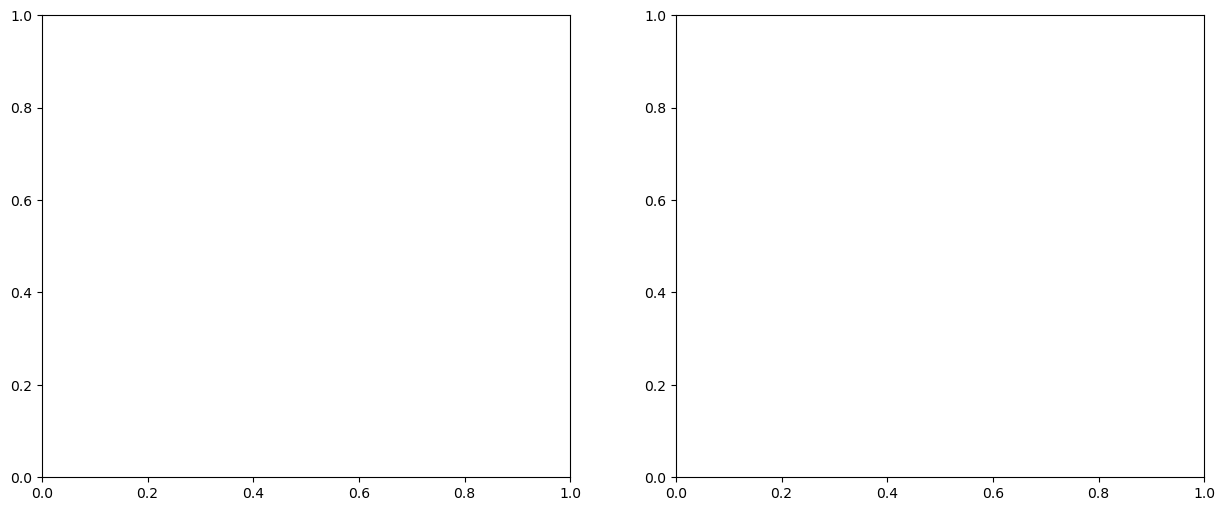

In [10]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(m_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("m")

ax1.plot(b_samples)
ax1.set_xlabel("Samples")
ax1.set_ylabel("b")

In [ ]:
inv_mass_matrix = np.array([0.01, 0.01, 0.01])
step_size = 1e-3

nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

In [ ]:
initial_position = {"m": -1.0, "b": 5.0, "log_f": jnp.log(0.5)}
initial_state = nuts.init(initial_position)
initial_state

In [ ]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, nuts.step, initial_state, 4_000)

m_samples = states.position["m"].block_until_ready()
b_samples = states.position["b"].block_until_ready()
#loc_samples = states.position["loc"].block_until_ready()
#scale_samples = jnp.exp(states.position["log_scale"])

In [ ]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(m_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("m")

ax1.plot(b_samples)
ax1.set_xlabel("Samples")
ax1.set_ylabel("b")